# Load all notebooks with Functions

In [10]:
%run ../Functions/Functions_Finalized.ipynb

# Configure Parameters

In [11]:
# PARAMETERS

ATTRIBUUT = "ndFreeOfAlcohol" # Select your target attribut                                          
numerieke_features = []# not used for FreeOfAlcohol

SAVE_MODEL = True #True # Wil je een oud model overschrijven met een nieuwe?
EPOCHS = 100

Classes_threshold = 11
Overig_threshold = 200 # Class beneden deze threshold, zal worden toegevoegd aan class: 'overig'

Upsample_size_TRAIN = 4000
Upsample_size_VAL = 1000
Upsample_size_TEST = 1000

balance_threshold_single_label = 100
upsample_single_label = 5000

downsampeling_needed = False

# Training Process loop

Downsamepling gebruiken als je een attribuut hebt die hele ongebalanceerde classes hebt (bijv. 5000 True, 5000 False en 20000 Empty), alles wordt dan even groot als de kleinste class (equal_classes_downsample). Als dit niet nodig is dan gebruik je imbalance_check_single_label. Zet boolean downsampeling_need op True in cmd 5 indien gewenst.

   index  ndFreeOfAlcohol
0   True              300
1  EMPTY              300
2  False              300
ATTRIBUUT:  ndFreeOfAlcohol
['EMPTY', 'False', 'True']
['EMPTY', 'False', 'True']
['EMPTY', 'False', 'True']


,gtin,gln,ndFreeOfAlcohol,EMPTY,False,True,Aantal_classes,class_num_ndFreeOfAlcohol,class_names_ndFreeOfAlcohol
0,3;15947E+12,38000000072,EMPTY,1,0,0,1,"[1, 0, 0]","[EMPTY, False, True]"
1,3;15947E+12,38000000072,EMPTY,1,0,0,1,"[1, 0, 0]","[EMPTY, False, True]"
2,3;15947E+12,38000000072,EMPTY,1,0,0,1,"[1, 0, 0]","[EMPTY, False, True]"
3,3;15947E+12,38000000072,EMPTY,1,0,0,1,"[1, 0, 0]","[EMPTY, False, True]"
4,4;00399E+12,38000000072,EMPTY,1,0,0,1,"[1, 0, 0]","[EMPTY, False, True]"
...,...,...,...,...,...,...,...,...,...
895,8;71755E+12,8;71242E+12,False,0,1,0,1,"[0, 1, 0]","[EMPTY, False, True]"
896,8;71755E+12,8;71242E+12,False,0,1,0,1,"[0, 1, 0]","[EMPTY, False, True]"
897,8;71795E+12,8;71242E+12,False,0,1,0,1,"[0, 1, 0]","[EMPTY, False, True]"
898,8;71795E+12,8;71242E+12,False,0,1,0,1,"[0, 1, 0]","[EMPTY, False, True]"


{'EMPTY': 300, 'False': 300, 'True': 300}


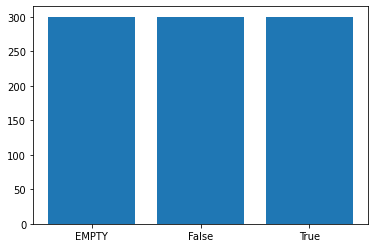

null entries =  0
Vocab size:  3400

Deze classes zijn laag in sample, en worden gebalanceerd:  ['EMPTY', 'False', 'True']
Dataframe length, VOOR balancing 38780
Samples available =  23290
Samples available =  7099
Samples available =  8391
Dataframe length, NA balancing 38780 



ValueError: too many dimensions 'str'

In [12]:
# Formateer
nd_controle = pd.read_csv('../dataset/NLP_processed.csv', sep=';')
padded_sequences = nd_controle[['padded_seq_','gtin']]

nd_controle[ATTRIBUUT] = nd_controle[ATTRIBUUT].fillna('EMPTY')
nd_controle = nd_controle.astype({ATTRIBUUT: str})
DF_merged, multi_label_flag,classes_available = create_overige_class(nd_controle, ATTRIBUUT,Classes_threshold, Overig_threshold)

#Prepare for trainimg
DF_merged = pd.merge(DF_merged, padded_sequences, on="gtin")
vocab_size = get_vocabulary_size(DF_merged)

if multi_label_flag == True:
    X_train, X_val, X_test, y_train, y_val, y_test, targets = total_split(DF_merged, numerieke_features, ATTRIBUUT)
else:
    if downsampeling_needed == True:
        DF_merged = equal_classes_downsample(classes_available, DF_merged)
    else:
        DF_merged = imbalance_check_single_label(classes_available, DF_merged, upsample_single_label)
    ytrain, yval, ytest, Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text = single_prep(numerieke_features, DF_merged, ATTRIBUUT)

In [ ]:
if multi_label_flag == True:
    classes = DF_merged['overig'].value_counts().index.tolist() # haal [0,1] en [1,0] als class eruit
    X_train, y_train = balance_multi_label(targets, y_train, X_train, classes, Upsample_size_TRAIN, balance_set = "TRAIN-SET") # Balance each sub-class TRAINING
    X_val, y_val = balance_multi_label(targets, y_val, X_val, classes, Upsample_size_VAL, balance_set = "VALIDATION-SET") # Balance each sub-class VALIDATION
    X_test, y_test = balance_multi_label(targets, y_test, X_test, classes, Upsample_size_TEST, balance_set = "TEST-SET") # Balance each sub-class TEST

    train_accuracies, val_accuracies, train_loss, val_loss,class_names, model = TRAINING_multi_label(X_train, X_val, X_test, y_train, y_val, y_test, numerieke_features, vocab_size, ATTRIBUUT, SAVE_MODEL) # Start training the model --> Multi label
else:
    model, model_history = TRAINING_single_label(Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text, vocab_size, EPOCHS, SAVE_MODEL)


In [ ]:
# Plot statistieken van de training fase
if multi_label_flag == True:
    plot_multiple_training(train_accuracies, val_accuracies, class_names, ATTRIBUUT, type_='Accuracy')
    plot_multiple_training(train_loss, val_loss, class_names, ATTRIBUUT, type_='Loss')
else:
    plot_single_label_training(model, model_history, Xtest_num, Xtest_text, ytest, ATTRIBUUT, DF_merged)
    